#  Storm Benchmarks 100000
Initial Statistics
------

storm-benchmarks   storm-benchmarks-20-1444757790  nobody  ACTIVE  3h 40m 51s      (workers)20      (executors)85      (tasks)85
This test was performed with the storm AdvertisingTopology reading from 5 kafka instances. The kafka instances were collectively fed 50000 json-serialized events per second.

### Counts
Counts were calculated by the topology in 100-second windows, and updated counts were written to the redis database once per second.

In the blue graph, you can see that the expected normal distribution of counts appears.

The green graph shows the amount of time in ms it took for a window to get its final update after the window officially ended. That is, once events stop being emitted for a window, this is how long it took for the final counts to be written. As expected, because of the 1s publishing period, the graph has a sharp dropoff at 1000ms. 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm

0

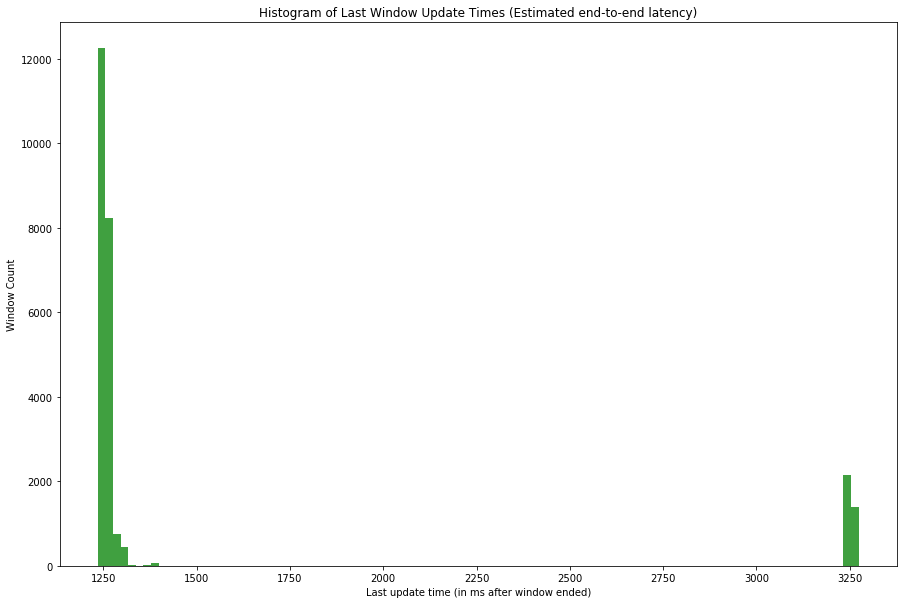

In [53]:
window_size_ms = 10000   #100 seconds (for me). Adjust to match your benchmark and common component.

update_times = np.loadtxt("./first_run/BEAM_SPARK/50000/updated.txt", dtype=int)
filtered_times = [x - window_size_ms for x in update_times if x >= window_size_ms]
plt.figure(num=None, figsize=(15, 10))
plt.hist(filtered_times, 100, density=0, facecolor='green', alpha=0.75)
plt.xlabel('Last update time (in ms after window ended)')
plt.ylabel('Window Count')
plt.title('Histogram of Last Window Update Times (Estimated end-to-end latency)')
0

## Percentiles

Percentiles for the last-update time. 90th percentile being within 1000ms or so indicates that the topology is keeping up with the throughput.

[1235. 1248. 1256. 1266. 3247. 3268. 3274.]


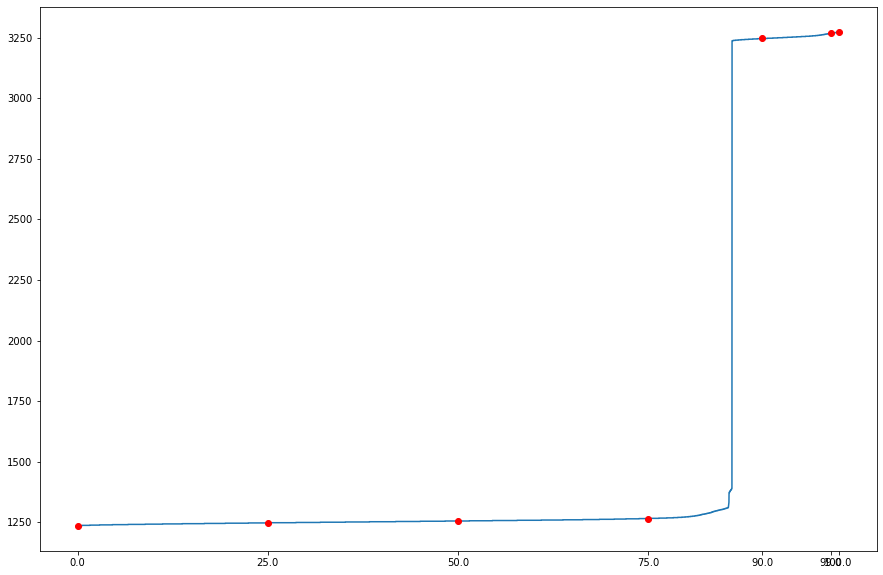

0th percentile: 1235
25th percentile: 1248
50th percentile: 1256
75th percentile: 1266
90th percentile: 3247
99th percentile: 3268
100th percentile: 3274


In [55]:

# Percentile values
p = np.array([0.0, 25.0, 50.0, 75.0, 90.0, 100.0])
sorted_times = np.sort(filtered_times)
perc = np.percentile(sorted_times, p)
print(perc)

plt.figure(num=None, figsize=(15, 10))

plt.plot(sorted_times)
# Place red dots on the percentiles
plt.plot((len(sorted_times)-1) * p/100., perc, 'ro')
#plt.xscale('symlog')
# Set tick locations and labels
plt.xticks((len(sorted_times)-1) * p/100., map(str, p))

plt.show()
for x in range(len(p)):
    print("%dth percentile: %d"%(p[x],perc[x]))

### *Late* Publishes
Here are the percentiles for the windows that were published *after* the expected 1000ms cutoff:

[1005. 1031. 1073. 1163. 1262. 1360. 1488. 1673.]


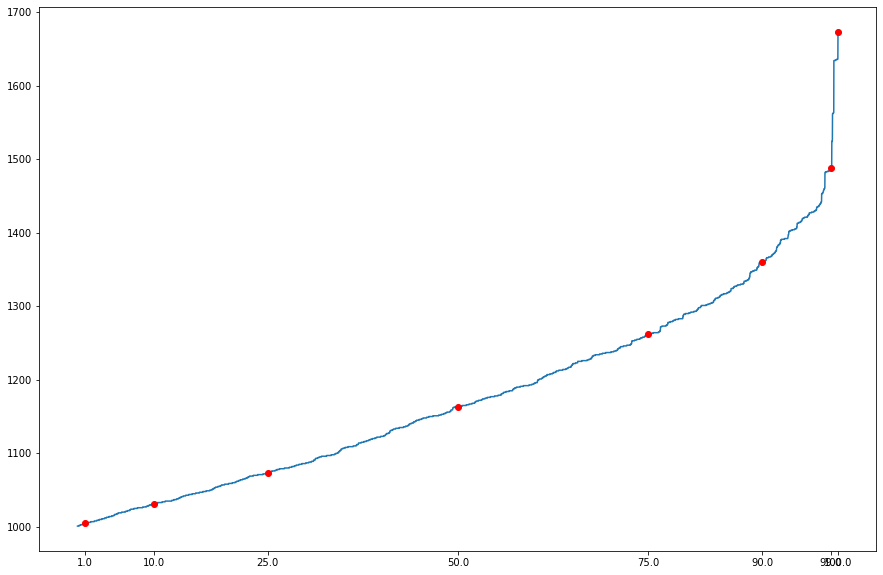

1th percentile: 1005
10th percentile: 1031
25th percentile: 1073
50th percentile: 1163
75th percentile: 1262
90th percentile: 1360
99th percentile: 1488
100th percentile: 1673


In [35]:
# Percentile values
q = [1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0, 100]
p = np.array([1.0, 10.0, 25.0, 50.0, 75.0, 90.0, 99.0, 100])
filtered_sorted_times = [x for x in sorted_times if x > 1000]
perc = np.percentile(filtered_sorted_times, q)
print(perc)

plt.figure(num=None, figsize=(15, 10))

plt.plot(filtered_sorted_times)
# Place red dots on the percentiles
plt.plot((len(filtered_sorted_times)-1) * p/100., perc, 'ro')
#plt.xscale('symlog')
# Set tick locations and labels
plt.xticks((len(filtered_sorted_times)-1) * p/100., map(str, p))

plt.show()
for x in range(len(p)):
    print("%dth percentile: %d"%(p[x],perc[x]))

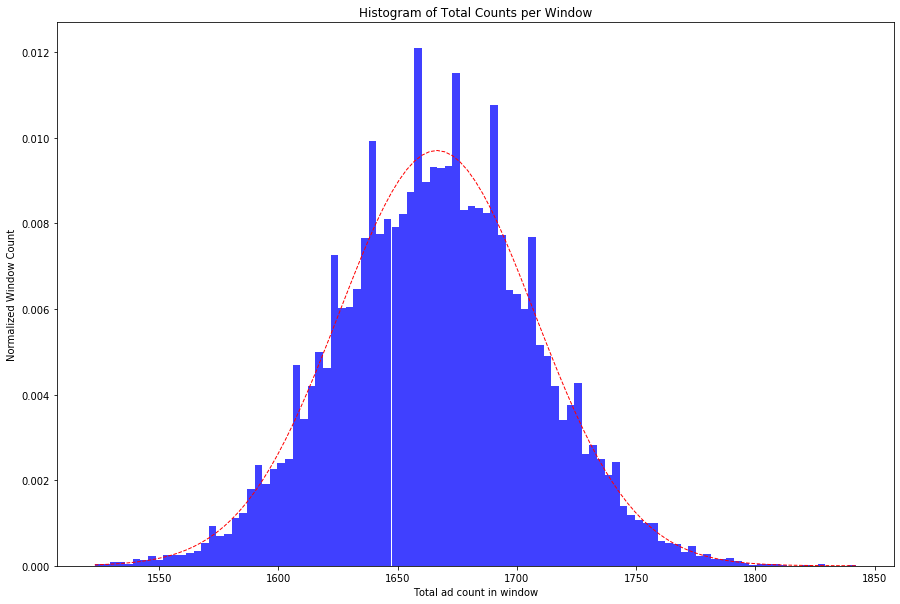

0

In [27]:
#Adjust this based on outliers you see. Start with 0 to find them.
filter_counts_below = 1500

seen_counts = np.loadtxt("seen.txt", dtype=int)
filtered_counts = [x for x in seen_counts if x >= filter_counts_below] 

plt.figure(num=None, figsize=(15, 10))
n, bins, patches = plt.hist(filtered_counts, 100, density=1, facecolor='blue', alpha=0.75)
(mu, sigma) = norm.fit(filtered_counts)
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)
plt.xlabel('Total ad count in window')
plt.ylabel('Normalized Window Count')
plt.title('Histogram of Total Counts per Window')
plt.show()
0

In [12]:
print("done")

done
